## **Imports** 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from glob import glob
import imgaug.augmenters as iaa
import imageio.v3 as iio

import os
import cv2
import numpy as np
import random
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms, datasets
from PIL import Image, ImageOps
from tqdm import tqdm
import mediapipe as mp
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

d:\Anaconda\envs\emotion39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cpu device


## **Sample of Enhanced Image using:**
- Histogram Equalization
- Edge-Preserving Bilateral Filter
- Sharpening kernel
- Bicubic Interpolation

In [ ]:
def enhance_and_upscale(img, target_size=(256, 256)):
    # Histogram Equalization
    equalized = cv2.equalizeHist(img)

    # Edge-Preserving Bilateral Filter
    smoothed = cv2.bilateralFilter(equalized, d=9, sigmaColor=75, sigmaSpace=75)

    # Sharpening kernel
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    sharpened = cv2.filter2D(smoothed, -1, sharpen_kernel)

    # Upscale using Bicubic Interpolation 
    upscaled = cv2.resize(sharpened, target_size, interpolation=cv2.INTER_CUBIC)

    return upscaled

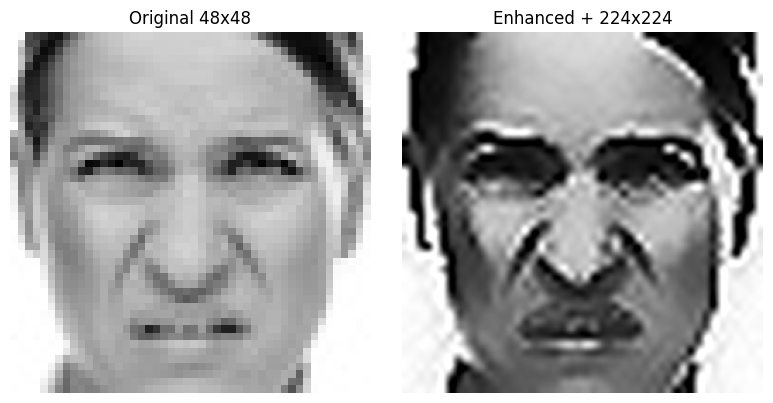

In [ ]:
img_path = r"D:\IIT BBS\Intern works\Flasho tech\expression_identifier\data\train\disgust\Training_680349.jpg"
original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
enhanced_upscaled = enhance_and_upscale(original, target_size=(256, 256))

# Display results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original, cmap='gray')
plt.title("Original 48x48")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_upscaled, cmap='gray')
plt.title("Enhanced + 256x256")
plt.axis('off')
plt.tight_layout()
plt.show()

## **FER 2013 Dataset Upscaling**

In [29]:
def process_folder(input_root, output_root, target_size=(256, 256)):
    input_root = Path(input_root)
    output_root = Path(output_root)
    
    # Walk through dataset structure
    for split in ['train', 'val', 'test']:
        split_dir = input_root / split
        for emotion_folder in split_dir.iterdir():
            if emotion_folder.is_dir():
                output_emotion_folder = output_root / split / emotion_folder.name
                output_emotion_folder.mkdir(parents=True, exist_ok=True)
                
                for img_file in tqdm(list(emotion_folder.glob("*.jpg")), desc=f"{split}/{emotion_folder.name}"):
                    img = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        continue  # Skip corrupted or unreadable images
                    enhanced_img = enhance_and_upscale(img, target_size)
                    save_path = output_emotion_folder / img_file.name
                    cv2.imwrite(str(save_path), enhanced_img)

In [30]:
process_folder(r"D:\IIT BBS\Intern works\Flasho tech\expression_identifier\data",
               r"D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013", 
               target_size=(256, 256))

test/surprise: 100%|██████████| 768/768 [00:19<00:00, 40.21it/s] 


## **Data Augmentation**
- **To mitigate class imbalance in FER 2013.**
- **A total of 32,931 Images are there.**

### ***Before Class Imbalance Mitigation:*** 
- Angry: 4323
- Disgust: 458
- Fear: 4558
- Happy: 8589
- Neutral: 5938
- Sad: 5314
- Surprise: 3751

- Total: 32,931 images

### ***After Class Imbalance Mitigation:*** 
- Angry: 7056 images
- Disgust: 8418 images
- Fear: 6958 images
- Neutral: 6457 images
- Sad: 6660 images
- Surprise: 7225 images
- Happy: 8589 images

- Total: 51,363 images

In [35]:
base_dir = r"D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013"
target_total = 50000

In [38]:
# 1. Count images per emotion class
class_counts = {}
for split in ['train', 'val', 'test']:  # Iterate over splits (train, val, test)
    split_dir = os.path.join(base_dir, split)
    for emotion in os.listdir(split_dir):  # Iterate over emotion folders
        emotion_dir = os.path.join(split_dir, emotion)
        if os.path.isdir(emotion_dir):  # Ensure it’s a directory
            images = glob(os.path.join(emotion_dir, "*.jpg"))
            class_counts[emotion] = class_counts.get(emotion, 0) + len(images)

# 2. Determine how many images each emotion class should have
num_classes = len(class_counts)
target_per_class = target_total // num_classes
augmentation_plan = {cls: max(0, target_per_class - count) for cls, count in class_counts.items()}

# 3. Augment only needed classes
aug = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-20, 20)),
    iaa.GaussianBlur(sigma=(0.0, 1.0)),
    iaa.AdditiveGaussianNoise(scale=(5, 15)),
    iaa.LinearContrast((0.75, 1.5)),
])

print("Augmenting underrepresented classes...")
for split in ['train', 'val', 'test']:  # Iterate over splits (train, val, test)
    split_dir = os.path.join(base_dir, split)
    for emotion, num_to_add in augmentation_plan.items():
        if num_to_add <= 0:
            continue
        
        emotion_dir = os.path.join(split_dir, emotion)
        images = glob(os.path.join(emotion_dir, "*.jpg"))

        if len(images) == 0:
            print(f"Warning: No images found in {emotion_dir}. Skipping augmentation for this class.")
            continue

        for _ in tqdm(range(num_to_add), desc=f"Augmenting {emotion} in {split}"):
            img_path = random.choice(images)
            image = iio.imread(img_path)
            augmented = aug(image=image)
            new_name = f"aug_{random.randint(100000, 999999)}.jpg"
            iio.imwrite(os.path.join(emotion_dir, new_name), augmented)

Augmenting underrepresented classes...


Augmenting surprise in test: 100%|██████████| 3391/3391 [00:42<00:00, 80.30it/s] 


## ***MediaPipe Landmark Extraction***
- **Over Augmented and Upscaled FER 2013 Dataset**

In [41]:
mp_face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)
images_base = r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013'
landmarks_base = r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_Landmarks'


def extract_landmarks(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = mp_face_mesh.process(rgb_image)
    if not results.multi_face_landmarks:
        return None
    landmarks = results.multi_face_landmarks[0]
    return np.array([[lm.x, lm.y, lm.z] for lm in landmarks.landmark], dtype=np.float32)

print("Extracting and saving landmarks...")

for split in ['train', 'val', 'test']:
    for emotion in os.listdir(os.path.join(images_base, split)):
        image_dir = os.path.join(images_base, split, emotion)
        save_dir = os.path.join(landmarks_base, split, emotion)
        os.makedirs(save_dir, exist_ok=True)

        for img_path in tqdm(glob(os.path.join(image_dir, "*.jpg")), desc=f"{split}/{emotion}"):
            lm = extract_landmarks(img_path)
            if lm is not None:
                npy_path = os.path.join(save_dir, os.path.splitext(os.path.basename(img_path))[0] + ".npy")
                np.save(npy_path, lm)

Extracting and saving landmarks...


test/surprise: 100%|██████████| 4153/4153 [00:54<00:00, 76.20it/s] 


### **Deleting Images with no Landmarks**

In [42]:
def clean_unmatched_images(image_root, landmark_root):
    sets = ['train', 'val', 'test']
    deleted_count = 0

    for set_name in sets:
        image_set_dir = os.path.join(image_root, set_name)
        landmark_set_dir = os.path.join(landmark_root, set_name)

        print(f"\n🔍 Checking set: {set_name}")
        for emotion in os.listdir(image_set_dir):
            emotion_image_dir = os.path.join(image_set_dir, emotion)
            emotion_landmark_dir = os.path.join(landmark_set_dir, emotion)

            if not os.path.exists(emotion_landmark_dir):
                print(f"⚠️ Landmark folder missing: {emotion_landmark_dir}, skipping.")
                continue

            for fname in os.listdir(emotion_image_dir):
                if not fname.lower().endswith((".jpg", ".png")):
                    continue

                landmark_filename = fname.replace(".jpg", ".npy").replace(".png", ".npy")
                landmark_path = os.path.join(emotion_landmark_dir, landmark_filename)

                if not os.path.exists(landmark_path):
                    image_path = os.path.join(emotion_image_dir, fname)
                    os.remove(image_path)
                    deleted_count += 1
                    print(f"🗑️ Deleted: {image_path} (no corresponding landmark)")

    print(f"\n Cleanup complete. Total images deleted: {deleted_count}")

In [43]:
clean_unmatched_images(
    image_root= images_base,
    landmark_root= landmarks_base
)


🔍 Checking set: train
🗑️ Deleted: D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\train\angry\aug_322008.jpg (no corresponding landmark)
🗑️ Deleted: D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\train\angry\aug_322037.jpg (no corresponding landmark)
🗑️ Deleted: D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\train\angry\aug_322590.jpg (no corresponding landmark)
🗑️ Deleted: D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\train\angry\aug_322862.jpg (no corresponding landmark)
🗑️ Deleted: D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\train\angry\aug_322965.jpg (no corresponding landmark)
🗑️ Deleted: D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\train\angry\aug_323658.jpg (no corresponding landmark)
🗑️ Deleted: D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\train\angry\aug_324635.jpg (no 

### **Verifying Landmarks**


Showing landmarks for: TRAIN


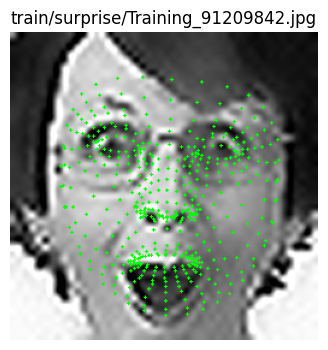

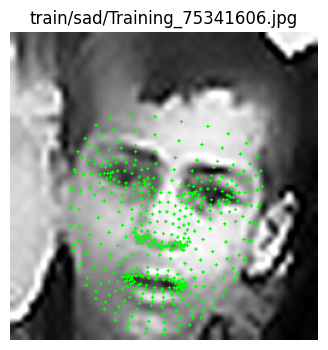

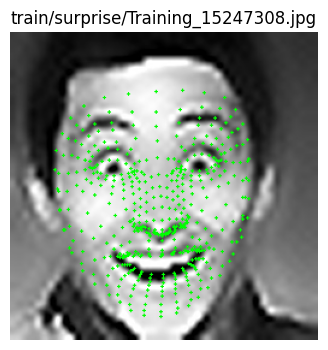

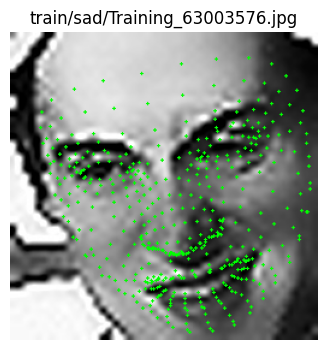


Showing landmarks for: VAL


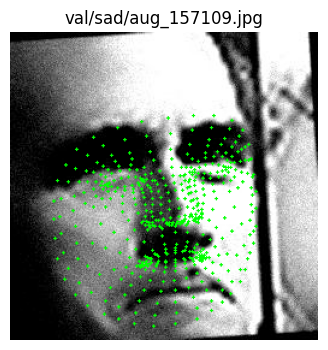

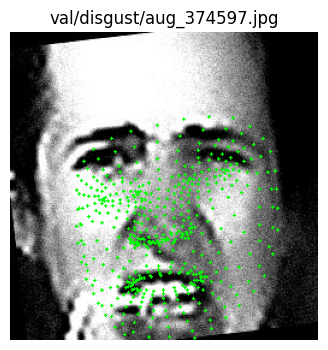


Showing landmarks for: TEST


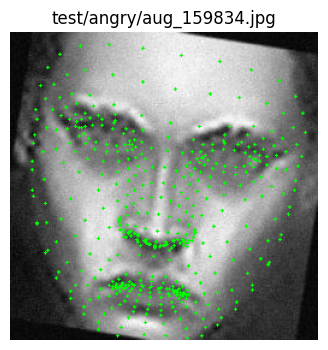

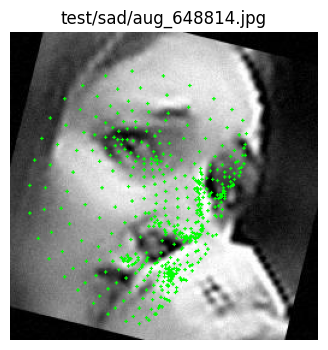

In [44]:
# How many to visualize
counts = {"train": 4, "val": 2, "test": 2}

def plot_landmarks_on_image(image_path, landmark_path):
    image = cv2.imread(image_path)
    if image is None or not os.path.exists(landmark_path):
        return None
    
    landmarks = np.load(landmark_path)
    h, w, _ = image.shape
    for x, y, _ in landmarks:
        px, py = int(x * w), int(y * h)
        cv2.circle(image, (px, py), 1, (0, 255, 0), -1)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

for split, count in counts.items():
    print(f"\nShowing landmarks for: {split.upper()}")
    all_images = []
    split_path = os.path.join(images_base, split)

    for emotion in os.listdir(split_path):
        emotion_folder = os.path.join(split_path, emotion)
        image_files = glob(os.path.join(emotion_folder, "*.jpg"))
        all_images.extend(image_files)

    sampled = random.sample(all_images, min(count, len(all_images)))

    for img_path in sampled:
        emotion = os.path.basename(os.path.dirname(img_path))
        filename_wo_ext = os.path.splitext(os.path.basename(img_path))[0]
        landmark_path = os.path.join(landmarks_base, split, emotion, filename_wo_ext + ".npy")

        result_img = plot_landmarks_on_image(img_path, landmark_path)
        if result_img is not None:
            plt.figure(figsize=(4, 4))
            plt.imshow(result_img)
            plt.title(f"{split}/{emotion}/{os.path.basename(img_path)}")
            plt.axis('off')
            plt.show()

## ***Get Dataset***

In [2]:
data_root = r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013'
landmark_root = r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_Landmarks'
splits = ['train', 'val', 'test']
image_extensions = ('.jpg', '.jpeg', '.png')

In [4]:
class HybridFERDataset(Dataset):
    def __init__(self, image_folder, landmark_folder, transform=None):
        self.image_folder = image_folder
        self.landmark_folder = landmark_folder
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        self._prepare_dataset()

    def _prepare_dataset(self):
        """Collect all image paths and corresponding landmark paths"""
        for label_name in sorted(os.listdir(self.image_folder)):
            class_dir = os.path.join(self.image_folder, label_name)
            if not os.path.isdir(class_dir):
                continue

            # Assign numeric label
            if label_name not in self.class_to_idx:
                self.class_to_idx[label_name] = len(self.class_to_idx)

            # Find images and corresponding landmarks
            image_paths = [
                os.path.join(class_dir, f)
                for f in os.listdir(class_dir)
                if f.lower().endswith(('.png', '.jpg'))
            ]
            for img_path in image_paths:
                filename = os.path.basename(img_path)
                landmark_path = os.path.join(
                    self.landmark_folder, label_name, filename.replace(".png", ".npy").replace(".jpg", ".npy")
                )
                if os.path.exists(landmark_path):
                    self.samples.append((img_path, landmark_path, self.class_to_idx[label_name]))
                else:
                    print(f"Missing landmark: {landmark_path}")

        print(f"Loaded {len(self.samples)} total samples from '{self.image_folder}'.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, lm_path, label = self.samples[idx]

        # Load grayscale image
        image = Image.open(img_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        # Load landmarks
        landmarks = torch.from_numpy(np.load(lm_path)).float().flatten()

        return image, landmarks, label

## ***ResEmoteNet Hybrid Model***

In [5]:
# # Updated SE Block
# class SEBlock(nn.Module):
#     def __init__(self, in_channels, reduction=16):
#         super().__init__()
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Linear(in_channels, in_channels // reduction, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Linear(in_channels // reduction, in_channels, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         b, c, _, _ = x.size()
#         y = self.pool(x).view(b, c)
#         y = self.fc(y).view(b, c, 1, 1)
#         return x * y.expand_as(x)

# # Updated Residual Block
# class ResidualBlock(nn.Module):
#     def __init__(self, in_ch, out_ch, stride=1):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride, 1)
#         self.bn1 = nn.BatchNorm2d(out_ch)
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
#         self.bn2 = nn.BatchNorm2d(out_ch)
#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_ch != out_ch:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_ch, out_ch, 1, stride, 0),
#                 nn.BatchNorm2d(out_ch)
#             )

#     def forward(self, x):
#         identity = self.shortcut(x)
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = self.bn2(self.conv2(x))
#         x += identity
#         return F.relu(x)

# # Visual Backbone (GREYSCALE updated)
# class ResEmoteNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 64, 7, stride=2, padding=3),  # Updated to grayscale input (1 channel)
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2)  # (B, 64, 56, 56)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(64, 128, 3, 1, 1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2)  # (B, 128, 28, 28)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(128, 256, 3, 1, 1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2)  # (B, 256, 14, 14)
#         )
#         self.se = SEBlock(256)
#         self.res1 = ResidualBlock(256, 512, 2)  # (B, 512, 7, 7)
#         self.res2 = ResidualBlock(512, 1024, 2)  # (B, 1024, 4, 4)
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.out_features = 1024

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.se(x)
#         x = self.res1(x)
#         x = self.res2(x)
#         x = self.pool(x).view(x.size(0), -1)
#         return x

# Landmark Branch with optional reconstruction head
class LandmarkBranch(nn.Module):
    def __init__(self, output_reconstruction=True):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1404, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.output_reconstruction = output_reconstruction
        if output_reconstruction:
            self.decoder = nn.Sequential(
                nn.Linear(256, 512),
                nn.ReLU(),
                nn.Linear(512, 1404)  # Match input dimension for reconstruction
            )

    def forward(self, x):
        encoded = self.encoder(x)
        if self.output_reconstruction:
            decoded = self.decoder(encoded)
            return encoded, decoded
        else:
            return encoded, None


# Cross-Modality Fusion (optional)
class FusionModule(nn.Module):
    def __init__(self, img_dim, lm_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(img_dim + lm_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

    def forward(self, img_feat, lm_feat):
        x = torch.cat([img_feat, lm_feat], dim=1)
        return self.fc(x)


# # Hybrid Model with projection heads for contrastive loss
# class HybridEmotionModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.visual = ResEmoteNet()
#         self.landmarks = LandmarkBranch(output_reconstruction=True)
#         self.fusion = FusionModule(self.visual.out_features, 256)
#         self.classifier = nn.Linear(128, 7)

#         # Add projection heads for contrastive loss
#         self.projection_img = nn.Linear(1024, 128)
#         self.projection_lm = nn.Linear(256, 128)

#     def forward(self, img, lm):
#         img_feat = self.visual(img)                    # (B, 1024)
#         lm_feat, lm_recon = self.landmarks(lm)         # (B, 256), (B, 936)
#         fused = self.fusion(img_feat, lm_feat)         # (B, 128)
#         logits = self.classifier(fused)                # (B, 7)

#         # Project to same space for cosine contrastive loss
#         img_proj = self.projection_img(img_feat)       # (B, 128)
#         lm_proj = self.projection_lm(lm_feat)          # (B, 128)

#         return logits, img_proj, lm_proj, lm_recon

class ResNet18Gray(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pretrained resnet18
        base_model = models.resnet18(pretrained=True)

        # Modify first conv layer to accept 1 channel (grayscale)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = base_model.conv1.weight.data.mean(dim=1, keepdim=True)  # Average pretrained RGB weights

        # Copy all other layers
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4
        self.avgpool = base_model.avgpool

        self.out_features = 512  # ResNet18 final feature dim (before fc)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        return torch.flatten(x, 1)  # (B, 512)

class HybridEmotionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = ResNet18Gray()  # swapped in here
        self.landmarks = LandmarkBranch(output_reconstruction=True)
        self.fusion = FusionModule(self.visual.out_features, 256)
        self.classifier = nn.Linear(128, 7)

        # Add projection heads for contrastive loss
        self.projection_img = nn.Linear(self.visual.out_features, 128)
        self.projection_lm = nn.Linear(256, 128)

    def forward(self, img, lm):
        img_feat = self.visual(img)                    # (B, 512)
        lm_feat, lm_recon = self.landmarks(lm)         # (B, 256), (B, 1404)
        fused = self.fusion(img_feat, lm_feat)         # (B, 128)
        logits = self.classifier(fused)                # (B, 7)

        # Project to same space for cosine contrastive loss
        img_proj = self.projection_img(img_feat)       # (B, 128)
        lm_proj = self.projection_lm(lm_feat)          # (B, 128)

        return logits, img_proj, lm_proj, lm_recon


## ***Training Pipeline***

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),   # Force grayscale channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])     # Normalize for 1 channel
])


train_dataset = HybridFERDataset(
    image_folder= r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\train',
    landmark_folder= r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_Landmarks\train',
    transform=transform,
)

val_dataset = HybridFERDataset(
    image_folder= r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\val',
    landmark_folder =r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_Landmarks\val',
    transform=transform,
)

test_dataset = HybridFERDataset(
    image_folder= r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\test',
    landmark_folder= r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_Landmarks\test',
    transform=transform,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Using cpu device
Loaded 20327 total samples from 'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\train'.
Loaded 10937 total samples from 'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\val'.
Loaded 11226 total samples from 'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\Upscaled_FER_2013\test'.


In [8]:
# Initialize everything
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = HybridEmotionModel().to(device)
criterion_ce = nn.CrossEntropyLoss()
criterion_contrastive = nn.CosineEmbeddingLoss()
criterion_recon = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Training configuration
num_epochs = 40
patience = 8
start_epoch = 0
best_val_acc = 0
patience_counter = 0

# Lists to store history
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

Using cpu device


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Dell/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:36<00:00, 1.30MB/s]


In [9]:
# Load checkpoint if it exists
checkpoint_path = 'FER_NEW_checkpoint.pth'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']
    patience_counter = checkpoint['patience_counter']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    test_losses = checkpoint['test_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_accuracies = checkpoint['val_accuracies']
    test_accuracies = checkpoint['test_accuracies']
    print(f"Resumed training from epoch {start_epoch}")

RuntimeError: Error(s) in loading state_dict for HybridEmotionModel:
	Missing key(s) in state_dict: "visual.conv1.weight", "visual.bn1.weight", "visual.bn1.bias", "visual.bn1.running_mean", "visual.bn1.running_var", "visual.layer1.0.conv1.weight", "visual.layer1.0.bn1.weight", "visual.layer1.0.bn1.bias", "visual.layer1.0.bn1.running_mean", "visual.layer1.0.bn1.running_var", "visual.layer1.0.conv2.weight", "visual.layer1.0.bn2.weight", "visual.layer1.0.bn2.bias", "visual.layer1.0.bn2.running_mean", "visual.layer1.0.bn2.running_var", "visual.layer1.1.conv1.weight", "visual.layer1.1.bn1.weight", "visual.layer1.1.bn1.bias", "visual.layer1.1.bn1.running_mean", "visual.layer1.1.bn1.running_var", "visual.layer1.1.conv2.weight", "visual.layer1.1.bn2.weight", "visual.layer1.1.bn2.bias", "visual.layer1.1.bn2.running_mean", "visual.layer1.1.bn2.running_var", "visual.layer2.0.conv1.weight", "visual.layer2.0.bn1.weight", "visual.layer2.0.bn1.bias", "visual.layer2.0.bn1.running_mean", "visual.layer2.0.bn1.running_var", "visual.layer2.0.conv2.weight", "visual.layer2.0.bn2.weight", "visual.layer2.0.bn2.bias", "visual.layer2.0.bn2.running_mean", "visual.layer2.0.bn2.running_var", "visual.layer2.0.downsample.0.weight", "visual.layer2.0.downsample.1.weight", "visual.layer2.0.downsample.1.bias", "visual.layer2.0.downsample.1.running_mean", "visual.layer2.0.downsample.1.running_var", "visual.layer2.1.conv1.weight", "visual.layer2.1.bn1.weight", "visual.layer2.1.bn1.bias", "visual.layer2.1.bn1.running_mean", "visual.layer2.1.bn1.running_var", "visual.layer2.1.conv2.weight", "visual.layer2.1.bn2.weight", "visual.layer2.1.bn2.bias", "visual.layer2.1.bn2.running_mean", "visual.layer2.1.bn2.running_var", "visual.layer3.0.conv1.weight", "visual.layer3.0.bn1.weight", "visual.layer3.0.bn1.bias", "visual.layer3.0.bn1.running_mean", "visual.layer3.0.bn1.running_var", "visual.layer3.0.conv2.weight", "visual.layer3.0.bn2.weight", "visual.layer3.0.bn2.bias", "visual.layer3.0.bn2.running_mean", "visual.layer3.0.bn2.running_var", "visual.layer3.0.downsample.0.weight", "visual.layer3.0.downsample.1.weight", "visual.layer3.0.downsample.1.bias", "visual.layer3.0.downsample.1.running_mean", "visual.layer3.0.downsample.1.running_var", "visual.layer3.1.conv1.weight", "visual.layer3.1.bn1.weight", "visual.layer3.1.bn1.bias", "visual.layer3.1.bn1.running_mean", "visual.layer3.1.bn1.running_var", "visual.layer3.1.conv2.weight", "visual.layer3.1.bn2.weight", "visual.layer3.1.bn2.bias", "visual.layer3.1.bn2.running_mean", "visual.layer3.1.bn2.running_var", "visual.layer4.0.conv1.weight", "visual.layer4.0.bn1.weight", "visual.layer4.0.bn1.bias", "visual.layer4.0.bn1.running_mean", "visual.layer4.0.bn1.running_var", "visual.layer4.0.conv2.weight", "visual.layer4.0.bn2.weight", "visual.layer4.0.bn2.bias", "visual.layer4.0.bn2.running_mean", "visual.layer4.0.bn2.running_var", "visual.layer4.0.downsample.0.weight", "visual.layer4.0.downsample.1.weight", "visual.layer4.0.downsample.1.bias", "visual.layer4.0.downsample.1.running_mean", "visual.layer4.0.downsample.1.running_var", "visual.layer4.1.conv1.weight", "visual.layer4.1.bn1.weight", "visual.layer4.1.bn1.bias", "visual.layer4.1.bn1.running_mean", "visual.layer4.1.bn1.running_var", "visual.layer4.1.conv2.weight", "visual.layer4.1.bn2.weight", "visual.layer4.1.bn2.bias", "visual.layer4.1.bn2.running_mean", "visual.layer4.1.bn2.running_var". 
	Unexpected key(s) in state_dict: "visual.conv2.0.weight", "visual.conv2.0.bias", "visual.conv2.1.weight", "visual.conv2.1.bias", "visual.conv2.1.running_mean", "visual.conv2.1.running_var", "visual.conv2.1.num_batches_tracked", "visual.conv3.0.weight", "visual.conv3.0.bias", "visual.conv3.1.weight", "visual.conv3.1.bias", "visual.conv3.1.running_mean", "visual.conv3.1.running_var", "visual.conv3.1.num_batches_tracked", "visual.se.fc.0.weight", "visual.se.fc.2.weight", "visual.res1.conv1.weight", "visual.res1.conv1.bias", "visual.res1.bn1.weight", "visual.res1.bn1.bias", "visual.res1.bn1.running_mean", "visual.res1.bn1.running_var", "visual.res1.bn1.num_batches_tracked", "visual.res1.conv2.weight", "visual.res1.conv2.bias", "visual.res1.bn2.weight", "visual.res1.bn2.bias", "visual.res1.bn2.running_mean", "visual.res1.bn2.running_var", "visual.res1.bn2.num_batches_tracked", "visual.res1.shortcut.0.weight", "visual.res1.shortcut.0.bias", "visual.res1.shortcut.1.weight", "visual.res1.shortcut.1.bias", "visual.res1.shortcut.1.running_mean", "visual.res1.shortcut.1.running_var", "visual.res1.shortcut.1.num_batches_tracked", "visual.res2.conv1.weight", "visual.res2.conv1.bias", "visual.res2.bn1.weight", "visual.res2.bn1.bias", "visual.res2.bn1.running_mean", "visual.res2.bn1.running_var", "visual.res2.bn1.num_batches_tracked", "visual.res2.conv2.weight", "visual.res2.conv2.bias", "visual.res2.bn2.weight", "visual.res2.bn2.bias", "visual.res2.bn2.running_mean", "visual.res2.bn2.running_var", "visual.res2.bn2.num_batches_tracked", "visual.res2.shortcut.0.weight", "visual.res2.shortcut.0.bias", "visual.res2.shortcut.1.weight", "visual.res2.shortcut.1.bias", "visual.res2.shortcut.1.running_mean", "visual.res2.shortcut.1.running_var", "visual.res2.shortcut.1.num_batches_tracked", "visual.conv1.0.weight", "visual.conv1.0.bias", "visual.conv1.1.weight", "visual.conv1.1.bias", "visual.conv1.1.running_mean", "visual.conv1.1.running_var", "visual.conv1.1.num_batches_tracked". 
	size mismatch for fusion.fc.0.weight: copying a param with shape torch.Size([512, 1280]) from checkpoint, the shape in current model is torch.Size([512, 768]).
	size mismatch for projection_img.weight: copying a param with shape torch.Size([128, 1024]) from checkpoint, the shape in current model is torch.Size([128, 512]).

In [10]:
# Evaluation function
def evaluate(loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for images, landmarks, labels in loader:
            images, landmarks, labels = images.to(device), landmarks.to(device), labels.to(device)
            logits, _, _, _ = model(images, landmarks)
            loss = criterion_ce(logits, labels)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss_sum += loss.item()
    return loss_sum / len(loader), correct / total

In [11]:
# Training loop
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, landmarks, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, landmarks, labels = images.to(device), landmarks.to(device), labels.to(device)
        optimizer.zero_grad()

        logits, img_feat, lm_feat, lm_recon = model(images, landmarks)

        loss_ce = criterion_ce(logits, labels)
        sim_target = torch.ones(img_feat.size(0)).to(device)
        loss_contrastive = criterion_contrastive(img_feat, lm_feat, sim_target)
        loss_recon = criterion_recon(lm_recon, landmarks)

        total_loss = loss_ce + 0.1 * loss_contrastive + 0.05 * loss_recon

        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    val_loss, val_acc = evaluate(val_loader)
    test_loss, test_acc = evaluate(test_loader)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\src\models\FER_New_Best_Model.pth')
    else:
        patience_counter += 1
        print(f"No improvement in val accuracy for {patience_counter} epochs.")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # Save checkpoint after every epoch
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc,
        'patience_counter': patience_counter,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracies': test_accuracies
    }

    torch.save(checkpoint, checkpoint_path)

Epoch 1/40: 100%|██████████| 1271/1271 [1:09:58<00:00,  3.30s/it]


Epoch 1 | Train Loss: 1.4341 | Acc: 0.4652 | Val Loss: 1.1494 | Val Acc: 0.5658


Epoch 2/40: 100%|██████████| 1271/1271 [3:25:31<00:00,  9.70s/it]      


Epoch 2 | Train Loss: 1.0759 | Acc: 0.6076 | Val Loss: 1.1124 | Val Acc: 0.5972


Epoch 3/40: 100%|██████████| 1271/1271 [53:39<00:00,  2.53s/it]


Epoch 3 | Train Loss: 0.8841 | Acc: 0.6782 | Val Loss: 1.1072 | Val Acc: 0.6110


Epoch 4/40: 100%|██████████| 1271/1271 [45:37<00:00,  2.15s/it]


Epoch 4 | Train Loss: 0.7463 | Acc: 0.7367 | Val Loss: 1.1052 | Val Acc: 0.6194


Epoch 5/40: 100%|██████████| 1271/1271 [44:49<00:00,  2.12s/it]


Epoch 5 | Train Loss: 0.6216 | Acc: 0.7842 | Val Loss: 1.2408 | Val Acc: 0.5834
No improvement in val accuracy for 1 epochs.


Epoch 6/40: 100%|██████████| 1271/1271 [44:45<00:00,  2.11s/it]


Epoch 6 | Train Loss: 0.5218 | Acc: 0.8226 | Val Loss: 1.2588 | Val Acc: 0.6092
No improvement in val accuracy for 2 epochs.


Epoch 7/40: 100%|██████████| 1271/1271 [44:38<00:00,  2.11s/it]


Epoch 7 | Train Loss: 0.4020 | Acc: 0.8667 | Val Loss: 1.5339 | Val Acc: 0.5827
No improvement in val accuracy for 3 epochs.


Epoch 8/40: 100%|██████████| 1271/1271 [3:47:07<00:00, 10.72s/it]     


Epoch 8 | Train Loss: 0.3445 | Acc: 0.8880 | Val Loss: 1.5259 | Val Acc: 0.6003
No improvement in val accuracy for 4 epochs.


Epoch 9/40: 100%|██████████| 1271/1271 [1:01:20<00:00,  2.90s/it]


Epoch 9 | Train Loss: 0.2751 | Acc: 0.9128 | Val Loss: 1.5589 | Val Acc: 0.6067
No improvement in val accuracy for 5 epochs.


Epoch 10/40: 100%|██████████| 1271/1271 [47:08<00:00,  2.23s/it]


Epoch 10 | Train Loss: 0.2279 | Acc: 0.9289 | Val Loss: 1.8244 | Val Acc: 0.5819
No improvement in val accuracy for 6 epochs.


Epoch 11/40:  82%|████████▏ | 1038/1271 [38:57<08:44,  2.25s/it]


KeyboardInterrupt: 

In [ ]:
print("Epochs:", epoch)
print("Train Losses:", len(train_losses))
print("Validation Losses:", len(val_losses))
print("Train Accuracies:", len(train_accuracies))
print("Validation Accuracies:", len(val_accuracies))

Epochs: 39
Train Losses: 40
Validation Losses: 40
Train Accuracies: 40
Validation Accuracies: 40


In [ ]:
# Save results
df = pd.DataFrame({
    'Epoch': list(range(1, len(train_losses)+1)),
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
})
df.to_csv("expw_training_results.csv", index=False)

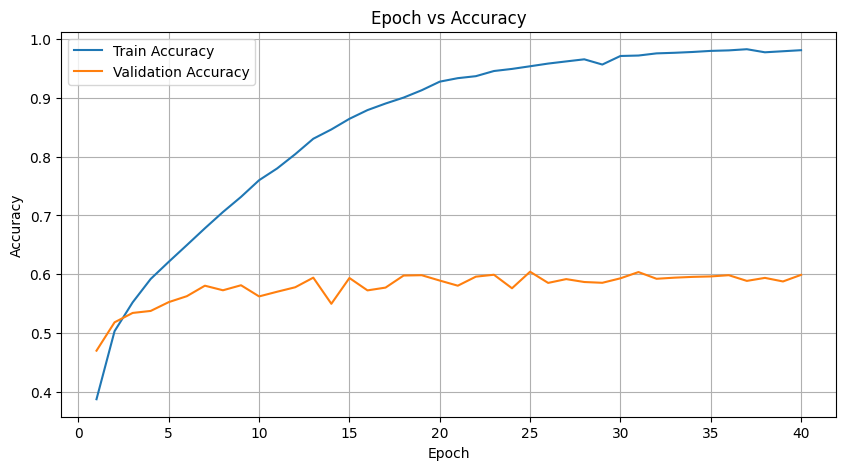

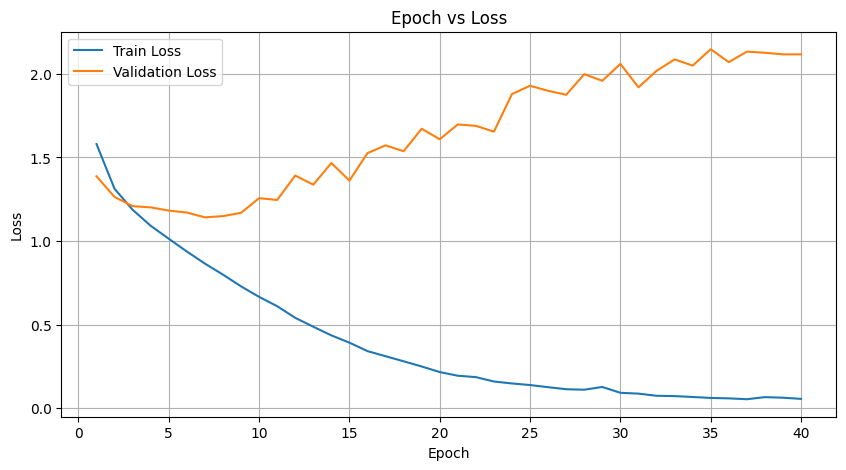

In [ ]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## ***Testing***

In [ ]:
# Set the device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')


# Load the model
model = ResEmoteNet().to(device)
checkpoint = torch.load('best_model.pth', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


# Apply the transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])


# Function to classify the image
def classify_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        prob = F.softmax(output, dim=1)
    scores = prob.cpu().numpy().flatten()
    rounded_scores = [round(score, 2) for score in scores]
    return rounded_scores


# Function to append the results to a list
def process_folder(folder_path):
    results = []
    for img_filename in os.listdir(folder_path):
        if img_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, img_filename)
            scores = classify_image(img_path)
            results.append([img_path] + scores) 
    return results


def main(folder_path):
    results = process_folder(folder_path)
    header = ['filepath', 'happy', 'surprise', 'sad', 'anger', 'disgust', 'fear', 'neutral']
    with open('testfile.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(results)
        

# Change the directory for the test folder        
main('path/to/test/folder')

In [ ]:
import os
import shutil
import random

# Define paths
train_folder = r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\data\train'
val_folder = r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\data\val'

# Make sure the validation folder exists
os.makedirs(val_folder, exist_ok=True)

# List of emotions (the names of the 7 emotion categories)
emotion_folders = sorted(os.listdir(train_folder))

# Move 20% of images from train folder to val folder
for emotion in emotion_folders:
    # Define source (train) and destination (val) paths for each emotion
    train_emotion_folder = os.path.join(train_folder, emotion)
    val_emotion_folder = os.path.join(val_folder, emotion)

    # Make sure the destination folder exists
    os.makedirs(val_emotion_folder, exist_ok=True)

    # List all images in the train emotion folder
    image_files = [f for f in os.listdir(train_emotion_folder) if f.lower().endswith(('.jpg', '.png'))]

    # Calculate the number of images to move (20%)
    num_images_to_move = int(len(image_files) * 0.2)

    # Randomly select 20% of images to move
    images_to_move = random.sample(image_files, num_images_to_move)

    # Move each selected image from train to val folder
    for image_file in images_to_move:
        source_image_path = os.path.join(train_emotion_folder, image_file)
        destination_image_path = os.path.join(val_emotion_folder, image_file)

        shutil.move(source_image_path, destination_image_path)

    print(f"Moved {num_images_to_move} images from {emotion} folder to validation.")

print("Image moving completed.")

In [ ]:
import os

# Define the paths
val_folder = r'D:\IIT BBS\Intern works\Flasho tech\expression_identifier\data\val'

# List of emotion categories
emotion_folders = sorted(os.listdir(val_folder))

# Rename images in the val folder
for emotion in emotion_folders:
    val_emotion_folder = os.path.join(val_folder, emotion)

    # Check if the emotion folder exists
    if os.path.isdir(val_emotion_folder):
        # List all files in the emotion folder
        image_files = [f for f in os.listdir(val_emotion_folder) if f.lower().endswith(('.jpg', '.png'))]

        # Rename files
        for image_file in image_files:
            # Extract the original image name (without the extension)
            base_name, extension = os.path.splitext(image_file)
            
            # Replace 'Training_' with 'Val_'
            new_base_name = base_name.replace("Training_", "Val_")
            
            # Construct the new file name
            new_image_name = new_base_name + extension
            old_image_path = os.path.join(val_emotion_folder, image_file)
            new_image_path = os.path.join(val_emotion_folder, new_image_name)

            # Rename the file
            os.rename(old_image_path, new_image_path)

            print(f"Renamed {image_file} to {new_image_name}")

print("File renaming completed.")


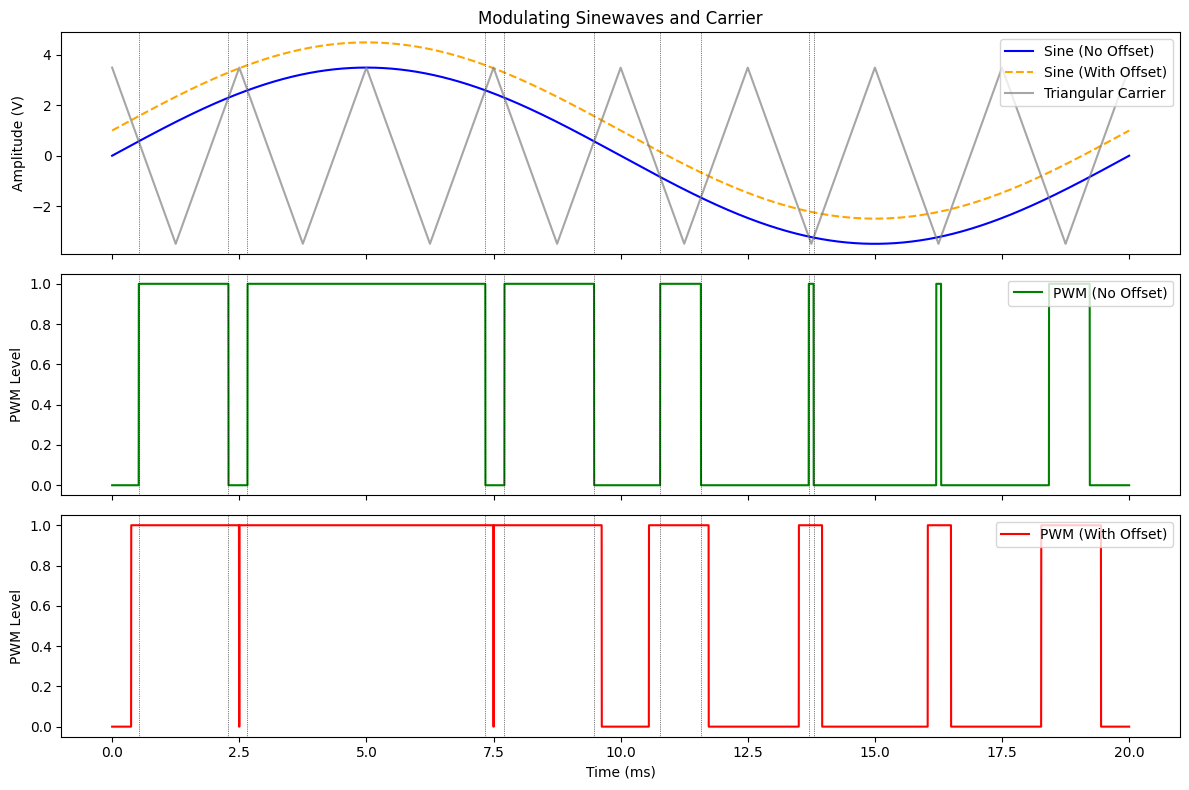

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fsine = 50           # Sinewave frequency (Hz)
fcarrier = 400   # Carrier frequency (Hz)
amplitude = 3.5      # Sinewave amplitude
offset = 1        # DC offset for second modulator
duration = 1 / fsine  # Duration of one sine wave cycle
sampling_rate = 1e6   # High enough for smooth waveform

t = np.linspace(0, duration, int(duration * sampling_rate))

# Generate sine waves
sine_normal = amplitude * np.sin(2 * np.pi * fsine * t)
sine_offset = amplitude * np.sin(2 * np.pi * fsine * t) + offset

# Generate triangle carrier
T = 1 / fcarrier  # Period of the carrier
triangle = 4 * amplitude * np.abs((t % T) / T - 0.5) - amplitude
triangle = np.where(triangle > amplitude, 2*amplitude - triangle, triangle)

# Generate PWM signals
pwm_normal = sine_normal > triangle
pwm_offset = sine_offset > triangle

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# First plot: sine and triangle
axs[0].plot(t * 1000, sine_normal, label='Sine (No Offset)', color='blue')
axs[0].plot(t * 1000, sine_offset, label='Sine (With Offset)', color='orange', linestyle='--')
axs[0].plot(t * 1000, triangle, label='Triangular Carrier', color='gray', alpha=0.7)
axs[0].set_ylabel("Amplitude (V)")
axs[0].legend(loc='upper right')
axs[0].set_title("Modulating Sinewaves and Carrier")

# Second plot: PWM without offset
axs[1].plot(t * 1000, pwm_normal, label='PWM (No Offset)', color='green')
axs[1].set_ylabel("PWM Level")
axs[1].legend(loc='upper right')

# Third plot: PWM with offset (shows dead time)
axs[2].plot(t * 1000, pwm_offset, label='PWM (With Offset)', color='red')
axs[2].set_ylabel("PWM Level")
axs[2].legend(loc='upper right')
axs[2].set_xlabel("Time (ms)")

# Vertical cursors (dotted lines where PWM transitions)
transition_indices = np.where(np.diff(pwm_normal.astype(int)) != 0)[0]
for idx in transition_indices[:10]:  # just mark first few for clarity
    for ax in axs:
        ax.axvline(t[idx] * 1000, color='black', linestyle='dotted', linewidth=0.5)

plt.tight_layout()
plt.show()


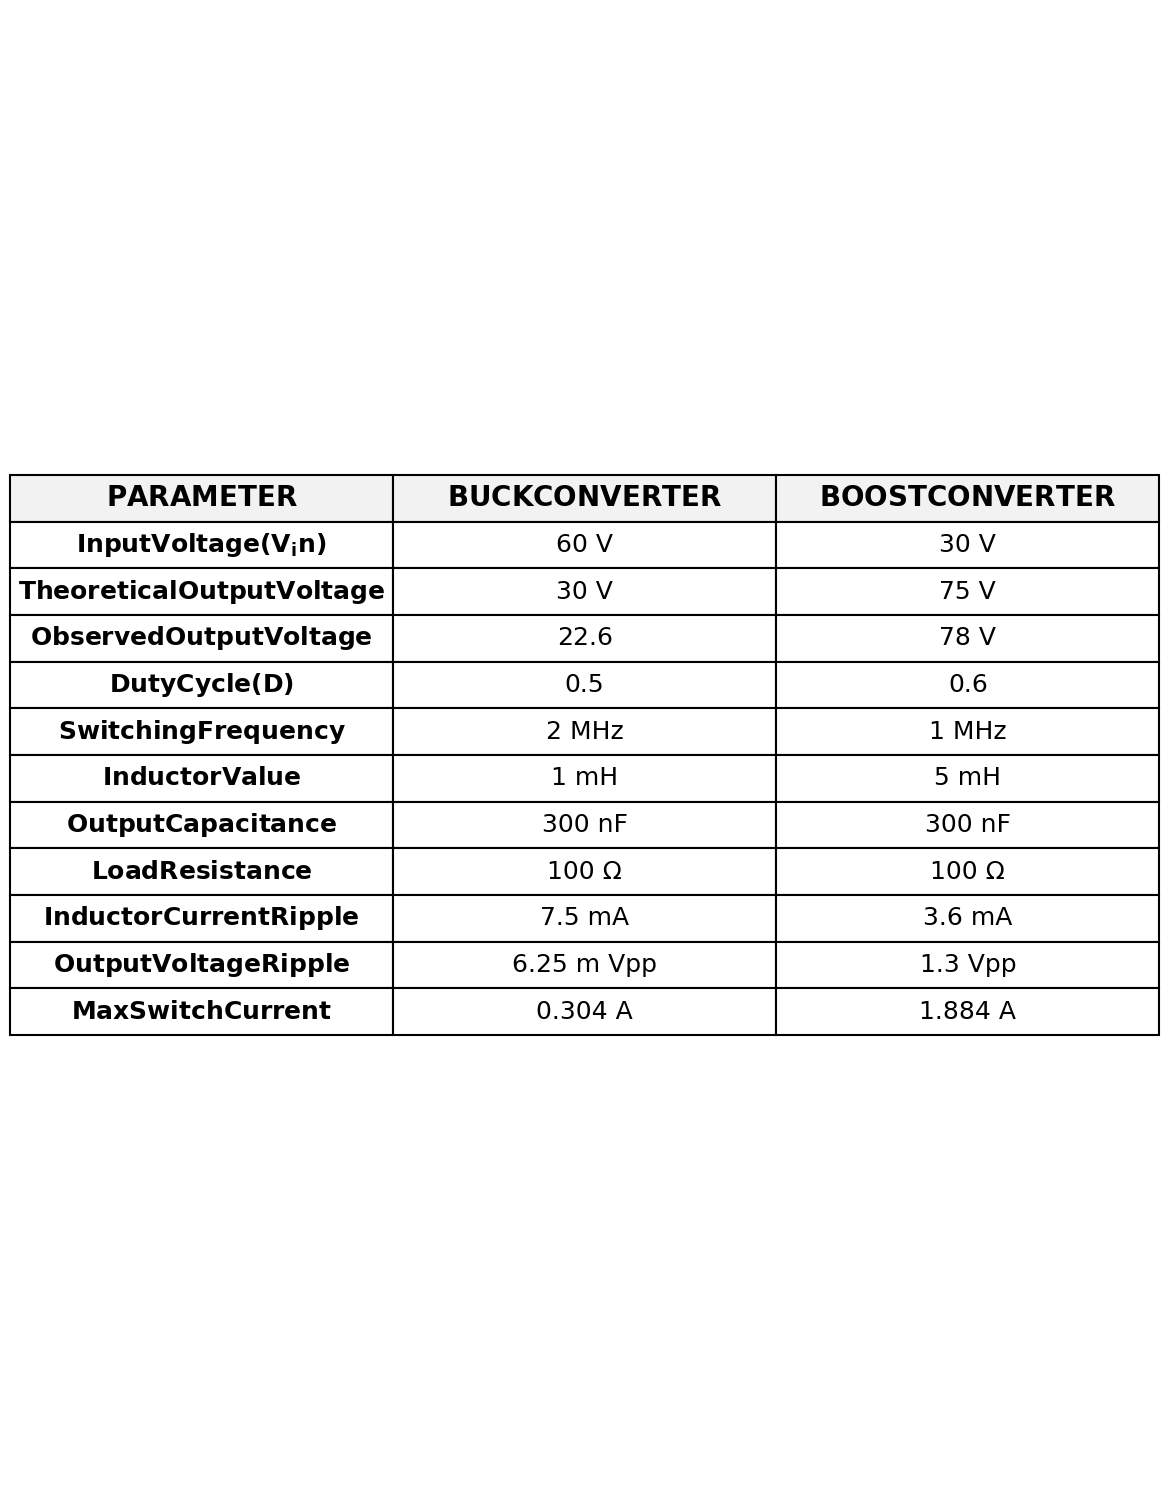

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your actual CSV filename or path
file_path = r"C:\Users\Dell\Desktop\Parameter-BuckConverter-BoostConverter.csv"
df = pd.read_csv(file_path)

# Convert header to uppercase
df.columns = [col.upper() for col in df.columns]

# Set up the matplotlib figure (increase width and height for larger cells)
fig, ax = plt.subplots(figsize=(13, len(df)*1.2 + 2))  # Wider and taller

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')

# Prepare cell text with first column bold
cell_text = []
for i, row in df.iterrows():
    row_list = []
    for j, val in enumerate(row):
        if j == 0:
            row_list.append(r"$\bf{" + str(val) + "}$")  # Bold first column
        else:
            row_list.append(val)
    cell_text.append(row_list)

# Create table with bold header
table = ax.table(
    cellText=cell_text,
    colLabels=[r"$\bf{" + col + "}$" for col in df.columns],  # Bold header
    loc='center',
    cellLoc='center',
    colLoc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(18)  # Larger font for readability
table.scale(1.5, 2.2)   # Increase width (1.5x) and height (2.2x) of cells

# Make header row bold and slightly larger
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_fontsize(20)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f2f2f2')
    if col == 0:
        cell.set_text_props(weight='bold')
    cell.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('converter_comparison_table.png', dpi=300)
plt.show()
